# Finite Difference Methods for Option Pricing

In this notebook, we demonstrate how to use **finite difference methods (FDMs)**
to price European options by numerically solving the **Black–Scholes PDE**:

$$
\frac{\partial V}{\partial t} 
+ \tfrac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} 
+ r S \frac{\partial V}{\partial S} 
- rV = 0
$$

where:

- $V(S,t)$ : option price at stock price $S$, time $t$  
- $r$ : risk-free interest rate  
- $\sigma$ : volatility  


We will use:
- **Explicit scheme**  
- **Implicit scheme**  
- **Crank–Nicolson scheme**  

and compare results against the **closed-form Black–Scholes solution**.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman" # Set font to Times New Roman
import sys
import os


# Add the repo root (one level up from notebooks) to Python path
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(repo_root)
# Import packages
from options_pricing.black_scholes import black_scholes_price
from options_pricing.finite_difference import finite_difference


## Parameters
We set up standard option parameters:


In [2]:
# Option and model parameters
S0     = 100     # initial stock price
K      = 100     # strike price
T      = 1.0     # time to maturity (years)
r      = 0.05    # risk-free rate
sigma  = 0.2     # volatility

# Grid parameters
M_stock = 200         # stock price steps
N_time  = 200         # baseline time steps
S_max   = 3 * K       # maximum stock price

# Build stock price grid
S_values = np.linspace(0, S_max, M_stock + 1)


## 2. Explicit FD Stability Condition

The explicit scheme is only stable if the time step \(\Delta t\) is small enough.  
A common stability condition is:

$
\Delta t \leq \frac{1}{\sigma^2 M^2 + rM}
$

We compute the minimum number of time steps \(N\) required to satisfy this.


In [3]:
dS = S_max / M_stock
dt_max1 = 1.0 / (sigma**2 * M_stock**2 + r * M_stock)   # worst-case at i=M
dt_max2 = (dS**2) / (sigma**2 * S_max**2)               # conservative spatial bound
dt_max  = min(dt_max1, dt_max2)

safety  = 1.10  # small safety factor
N_explicit = int(np.ceil(T / (dt_max / safety)))

print("Baseline N =", N_time)
print("Minimum stable N for Explicit FD =", N_explicit)


Baseline N = 200
Minimum stable N for Explicit FD = 1772


## Black–Scholes Benchmark

First, compute the analytical solution for a European call:


In [4]:
V_bs = black_scholes_price(S0, K, T, r, sigma, option_type="call")
print(f"Black–Scholes Call Price: {V_bs:.4f}")


Black–Scholes Call Price: 10.4506


## 3. Compute Option Values

Now let’s compute the option price using **explicit, implicit, and Crank–Nicolson** schemes.

Note: the explicit method requires a stability condition on `Δt` and `ΔS`.  
If the condition is not met, the solution diverges.

In [5]:
# Analytical solution
V_bs = np.array([black_scholes_price(S, K, T, r, sigma, option_type="call") 
                 for S in S_values])

# Finite difference methods
V_explicit = finite_difference(S_values, K, T, r, sigma, 
                               Smax=S_max, M=M_stock, N=N_explicit, 
                               option="call", method="explicit")

V_implicit = finite_difference(S_values, K, T, r, sigma, 
                               Smax=S_max, M=M_stock, N=N_time, 
                               option="call", method="implicit")

V_cn = finite_difference(S_values, K, T, r, sigma, 
                         Smax=S_max, M=M_stock, N=N_time, 
                         option="call", method="crank-nicolson")


c:\Users\datog\OneDrive\Desktop\options-pricing-library\options-pricing-library\options_pricing\black_scholes.py:17: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


## 4. Plot Results

We now plot all methods together to verify convergence.  
The Explicit FD is stable thanks to the adjusted number of time steps.


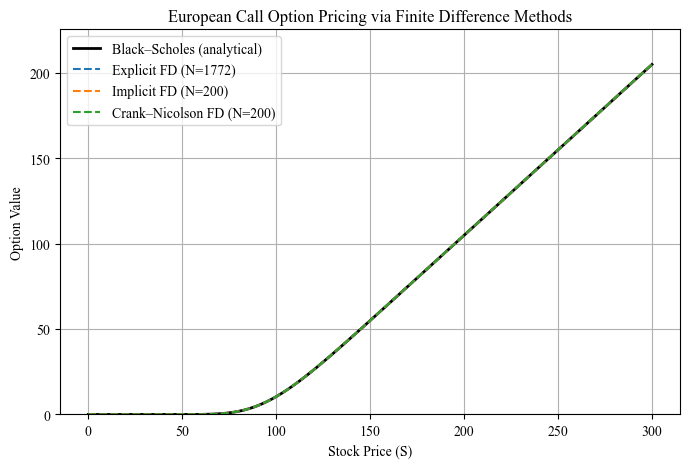

In [6]:
plt.figure(figsize=(8,5))
plt.plot(S_values, V_bs, label="Black–Scholes (analytical)", lw=2, c="black")
plt.plot(S_values, V_explicit, "--", label=f"Explicit FD (N={N_explicit})")
plt.plot(S_values, V_implicit, "--", label=f"Implicit FD (N={N_time})")
plt.plot(S_values, V_cn, "--", label=f"Crank–Nicolson FD (N={N_time})")
plt.xlabel("Stock Price (S)")
plt.ylabel("Option Value")
plt.title("European Call Option Pricing via Finite Difference Methods")
plt.legend()
plt.grid(True)
plt.ylim(0, 1.1*np.max(V_bs))
plt.show()


## 5. Observations
- The **Implicit** and **Crank–Nicolson** schemes lie almost exactly on top of the Black–Scholes curve.  
- The **Explicit** scheme now also matches, but only after increasing \(N\) to satisfy stability.  
- In practice, **Implicit** and **Crank–Nicolson** are preferred since they are unconditionally stable.  
